In [2]:
import json
import requests as rq
import pandas as pd
import numpy as np
import time
import itertools
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
G=nx.Graph()
import pymongo
from pymongo import MongoClient
import community

egonets_data = pd.read_csv('egonets_data.csv')

In [2]:
egonets_data['num_communities'] = egonets_data['num_communities']/egonets_data['Summ_totalGames']
egonets_data['num_components'] = egonets_data['num_components']/egonets_data['Summ_totalGames']

In [3]:
variable_names = ['Modularity', 'Components', 'Density', 'Coverage', 'Giant_Component_Coverage', 
                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']

egonets_data_numeric = egonets_data.iloc[:,3:11]
X = egonets_data_numeric.values

In [4]:
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import cluster
import yellowbrick
from sklearn.cluster import MiniBatchKMeans, KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

C:\ProgramData\Anaconda\envs\py36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
X_std = StandardScaler().fit_transform(X)

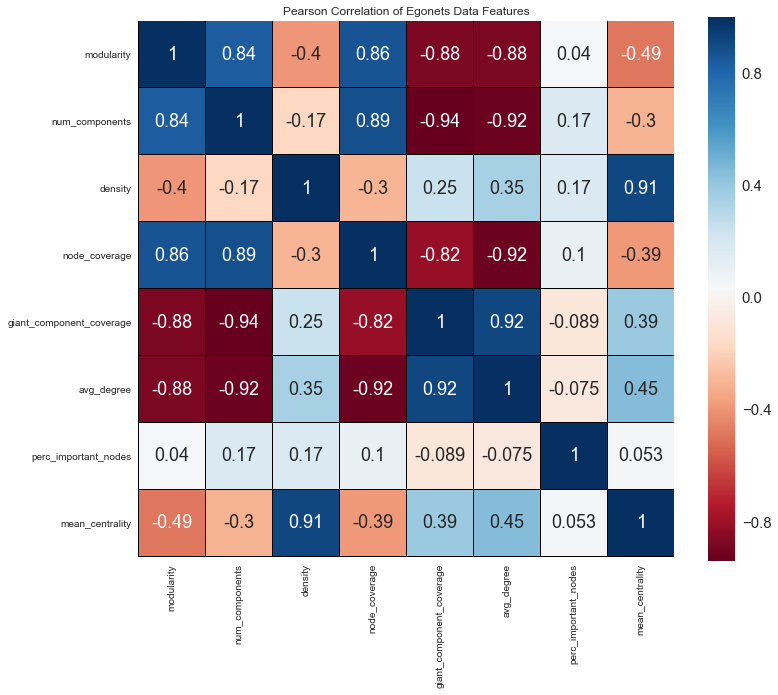

In [6]:
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
plt.title('Pearson Correlation of Egonets Data Features')
# Draw the heatmap using seaborn
sns.set(font_scale = 1.5)
sns.heatmap(egonets_data_numeric.corr(),linewidths=0.25,vmax=1.0, square=True, cmap="RdBu", linecolor='black', annot=True)

## Referencias: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
https://www.kaggle.com/arthurtok/principal-component-analysis-with-kmeans-visuals?scriptVersionId=1543947

In [86]:
#mean_vec = np.mean(X_std, axis=0)
#cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
#print('Covariance matrix \n%s' %cov_mat)
print('NumPy covariance matrix: \n%s' %np.cov(X_std.T))

NumPy covariance matrix: 
[[ 1.00228311  0.83988585 -0.40155032  0.86615743 -0.88610639 -0.88567136
   0.04052654 -0.48839342]
 [ 0.83988585  1.00228311 -0.16650427  0.88780642 -0.94036614 -0.92027036
   0.16876803 -0.30293854]
 [-0.40155032 -0.16650427  1.00228311 -0.29595024  0.25038474  0.35456257
   0.1719254   0.91257646]
 [ 0.86615743  0.88780642 -0.29595024  1.00228311 -0.81705588 -0.92443568
   0.10033158 -0.39384417]
 [-0.88610639 -0.94036614  0.25038474 -0.81705588  1.00228311  0.91856363
  -0.08890214  0.39512343]
 [-0.88567136 -0.92027036  0.35456257 -0.92443568  0.91856363  1.00228311
  -0.07508591  0.45118293]
 [ 0.04052654  0.16876803  0.1719254   0.10033158 -0.08890214 -0.07508591
   1.00228311  0.0528888 ]
 [-0.48839342 -0.30293854  0.91257646 -0.39384417  0.39512343  0.45118293
   0.0528888   1.00228311]]


In [87]:
cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[-0.42229193 -0.03307588  0.0742259  -0.01322061 -0.86386349 -0.24916258
  -0.06271817  0.05114257]
 [-0.41227058 -0.25031859  0.05265821 -0.16982694  0.38194486 -0.42978239
  -0.02886911  0.6358705 ]
 [ 0.21513446 -0.65619219  0.18643868 -0.10427945  0.0099221  -0.16301239
  -0.59795276 -0.30541186]
 [-0.41446918 -0.13252551  0.0599191   0.73140458  0.1031871   0.42634658
  -0.26968549  0.08342707]
 [ 0.41815914  0.15897102 -0.09074957  0.61839756 -0.03729484 -0.6291206
  -0.04119313  0.1016839 ]
 [ 0.43304352  0.097031   -0.07099564 -0.12081443 -0.25338365  0.35195624
  -0.39149883  0.66488645]
 [-0.03703148 -0.34840692 -0.93052738  0.01340473 -0.06415378  0.03069014
   0.07619992 -0.01778697]
 [ 0.264348   -0.57621282  0.27241673  0.1672298  -0.16553576  0.15573328
   0.635752    0.20021659]]

Eigenvalues 
[ 4.97185321  1.63829963  0.91871022  0.19635323  0.14347772  0.02016264
  0.07586733  0.05354087]


In [88]:
#variable_names = ['Modularity', 'Components', 'Density', 'Coverage', 'Giant_Component_Coverage', 
#                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']

for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


In [89]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
4.97185321072
1.63829962722
0.91871021566
0.196353229142
0.143477720406
0.0758673299236
0.0535408670724
0.0201626400379


In [36]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

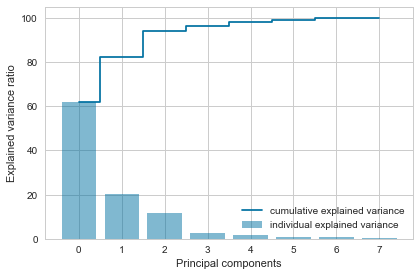

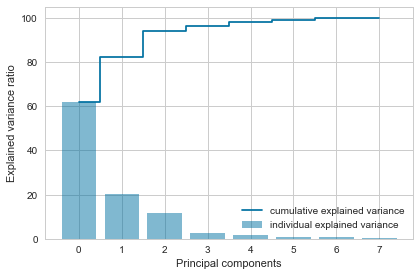

In [41]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(8), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(8), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [42]:
cum_var_exp

array([ 62.00659756,  82.43869428,  93.8964128 ,  96.34523724,
        98.13462339,  99.08080478,  99.74854111, 100.        ])

In [37]:
# cojo 3 para pasar del 90%
sklearn_pca = PCA(n_components=2)
X_sklearn = sklearn_pca.fit_transform(X_std)

In [38]:
X_sklearn

array([[  1.33694392e+01,   1.33036661e+01],
       [  4.96572019e+00,   8.79085306e+00],
       [ -3.65231312e-01,  -1.94978482e-01],
       [  6.47838210e+00,   3.32758449e+00],
       [  7.91284764e-01,  -1.94987353e-01],
       [ -2.33364506e+00,   3.95748289e-01],
       [  2.04361595e+00,  -9.02704467e-01],
       [ -9.63159877e-01,   6.09954515e-01],
       [  2.50773020e+00,  -5.61544581e-01],
       [  1.85010902e-01,  -2.93382822e-01],
       [ -1.44126287e+00,   3.28953160e-01],
       [  2.37190071e+00,  -7.76878861e-01],
       [  2.07238953e-01,  -1.31317001e-01],
       [ -2.29713187e+00,   8.04123403e-01],
       [ -1.95644395e+00,   3.99406197e-01],
       [  3.75970522e+00,  -2.36844757e-01],
       [ -3.25196524e+00,   8.86650738e-01],
       [ -2.15425516e+00,   3.06213779e-01],
       [  1.15938279e+00,   1.21739742e+00],
       [ -1.82768818e+00,   2.09024712e-01],
       [ -1.38574821e-01,  -2.88606485e-01],
       [  3.10840389e+00,  -8.41832851e-02],
       [  

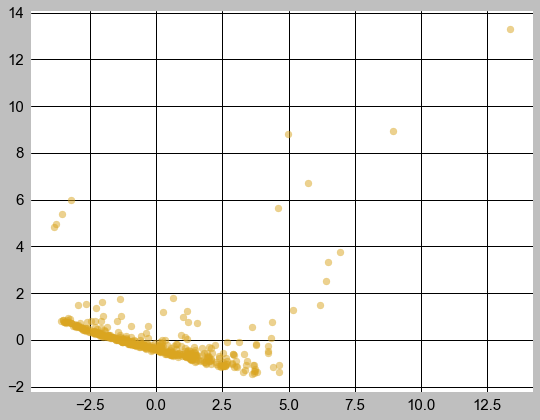

In [44]:
plt.figure(figsize = (9,7))
plt.scatter(X_sklearn[:,0],X_sklearn[:,1], c='goldenrod',alpha=0.5)
#plt.ylim(-3,3)
#plt.xlim(-5,5)
plt.show()

Estimated number of clusters: 7
Silhouette Coefficient: 0.640


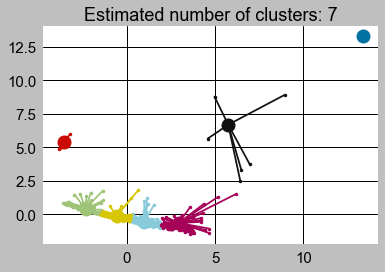

In [43]:
X = X_sklearn

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-60, damping = 0.8).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [42]:
df['Clusters_AF'] = pd.DataFrame(labels)
result_2 = pd.concat([result_2, df['Clusters_AF']], axis=1)

array([0, 7, 4, 5, 3, 6, 3, 2, 8, 4, 2, 8, 4, 6, 6, 8, 6, 6, 3, 2, 4, 8, 8,
       6, 2, 8, 6, 4, 6, 5, 4, 2, 6, 4, 4, 4, 3, 6, 2, 6, 3, 6, 2, 1, 2, 3,
       2, 2, 6, 6, 1, 4, 8, 3, 4, 8, 6, 6, 3, 6, 6, 6, 4, 4, 6, 8, 6, 8, 3,
       8, 2, 8, 4, 6, 6, 2, 8, 2, 4, 2, 2, 2, 6, 2, 6, 6, 2, 6, 4, 2, 4, 4,
       2, 3, 6, 3, 4, 3, 6, 2, 6, 2, 6, 4, 2, 3, 5, 6, 4, 4, 2, 6, 2, 3, 4,
       3, 6, 6, 2, 8, 6, 3, 2, 3, 8, 6, 8, 6, 2, 2, 2, 4, 4, 4, 2, 8, 3, 4,
       8, 2, 3, 2, 3, 3, 3, 3, 6, 2, 4, 2, 6, 3, 3, 3, 4, 8, 2, 2, 6, 8, 6,
       2, 8, 2, 3, 6, 3, 4, 3, 4, 2, 4, 3, 4, 3, 6, 3, 4, 4, 6, 4, 8, 3, 3,
       4, 4, 3, 2, 2, 8, 6, 2, 2, 3, 6, 8, 8, 2, 3, 8, 8, 2, 4, 4, 6, 2, 3,
       3, 4, 6, 3, 2, 3, 4, 8, 4, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 4, 3, 2, 8,
       4, 4, 6, 6, 4, 4, 2, 4, 2, 2, 4, 2, 3, 2, 6, 4, 6, 4, 6, 4, 4, 2, 2,
       8, 4, 2, 6, 8, 2, 6, 6, 2, 8, 2, 6, 4, 3, 4, 4, 6, 4, 2, 3, 2, 3, 3,
       2, 2, 6, 4, 6, 6, 2, 8, 3, 3, 6, 8, 4, 2, 2, 8, 8, 4, 3, 3, 6, 4, 8,
       4, 3,

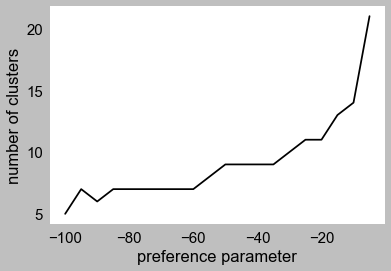

In [41]:
i = -100
x = []
y = []
while i < 0:
    af = AffinityPropagation(preference=i, damping = 0.8).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    x.append(i)
    y.append(n_clusters_)
    i = i + 5
    
plt.style.use('grayscale')
plt.grid(False)
plt.xlabel('preference parameter')
plt.ylabel('number of clusters')
plt.plot(x,y)
plt.savefig('preference_PCA.png', bbox_inches='tight')
plt.show()

# K-MEANS CON PCA

In [22]:
# K MEANS

visualizer = KElbowVisualizer(KMeans(), k=(2,12))

visualizer.fit(X_sklearn) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

NameError: name 'X_sklearn' is not defined

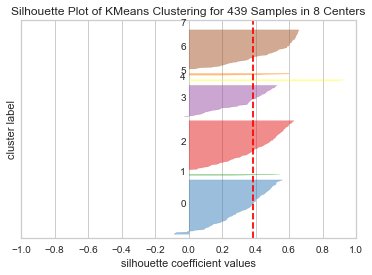

In [18]:
model = KMeans(8)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_sklearn) # Fit the training data to the visualizer
visualizer.poof()

In [20]:
# Set a 8 KMeans clustering
kmeans = KMeans(n_clusters=8)
# Compute cluster centers and predict cluster indices
X_clustered = kmeans.fit_predict(X_sklearn)

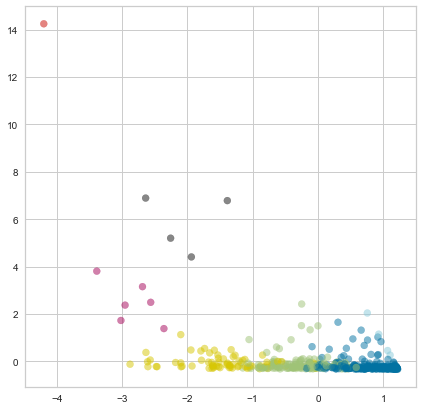

In [21]:
LABEL_COLOR_MAP = {0 : 'b',1 : 'g',2 : 'r', 3 : 'c',4 : 'm',5 : 'y', 6 : 'k',7 : 'b'}
label_color = [LABEL_COLOR_MAP[l] for l in X_clustered]

plt.figure(figsize = (7,7))
plt.scatter(X_sklearn[:,0],X_sklearn[:,2], c= label_color, alpha=0.5) 
plt.show()

In [97]:
# Create a temp dataframe from our PCA projection data "X_sklearn"
df = pd.DataFrame(X_sklearn)
#df = df[[0,1,2,3]] # only want to visualise relationships between first 3 projections
df['X_cluster'] = X_clustered

C:\ProgramData\Anaconda\envs\py36\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\statsmodels\nonparametric\bandwidths.py:22: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\ProgramData\Anaconda\envs\py36\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


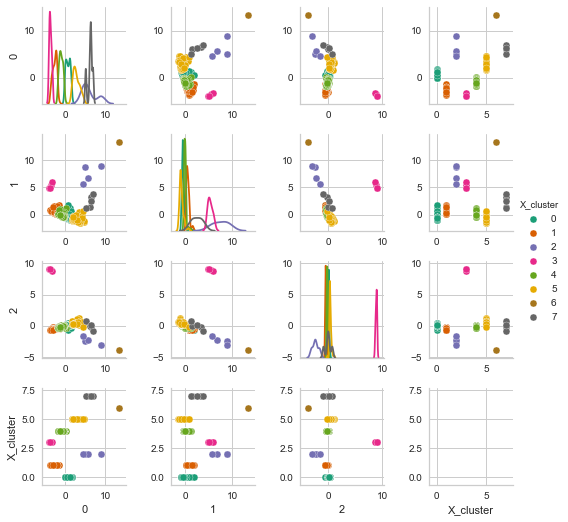

In [98]:
sns.pairplot(df, hue='X_cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

Si no me equivoco, ha cogido las tres primeras variables: 'Modularity', 'Components', 'Density'

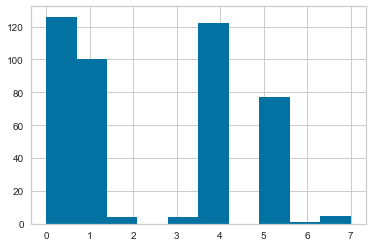

In [101]:
df['X_cluster'].hist()

Es decir, como se veía más arriba, sólo parece que haya 4 grandes grupos en realidad. ¿Qué debería hacer ahora? ¿Elimino los "outliers" para que quede más limpio?

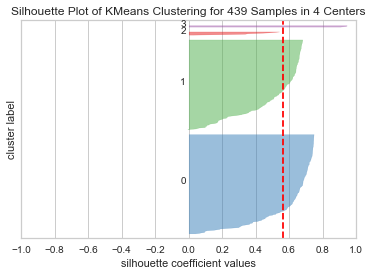

In [109]:
# Además, si suponemos 4 grupos, el K-Means te dice que vaya, que hay dos mucho más grandes que el resto
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_sklearn) # Fit the training data to the visualizer
visualizer.poof()

# K-MEANS SIN PCA

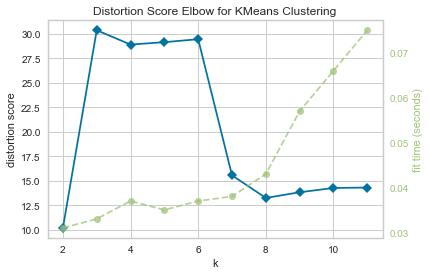

In [23]:
visualizer = KElbowVisualizer(KMeans(), k=(2,12))

visualizer.fit(X_std) # Fit the training data to the visualizer
visualizer.poof() # Draw/show/poof the data

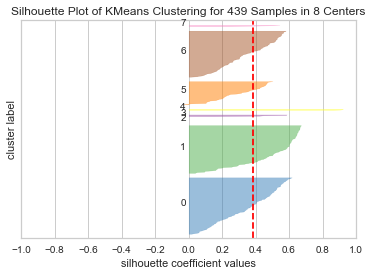

In [24]:
model = KMeans(8)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(X_std) # Fit the training data to the visualizer
visualizer.poof()

In [51]:
# Set a 8 KMeans clustering
kmeans = KMeans(n_clusters=8)
# Compute cluster centers and predict cluster indices
X_std_clusters = kmeans.fit_predict(X_std)

df['Cluster'] = pd.DataFrame(X_std_clusters)
df.head()

,0,Cluster
0,6,6
1,2,2
2,1,5
3,7,7
4,4,0


In [39]:
df.head()

,0
0,6
1,2
2,1
3,7
4,4


In [52]:
# Más pruebas

result_2 = pd.concat([egonets_data, df['Cluster']], axis=1)

In [53]:
result_2.head()

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result,Cluster
0,19459077,18,0.028986,0.042192,0.014493,0.389706,0.061594,1.000000,6.235294,0.058824,0.046569,19459077,BRONZE,Bot - ADC,Equipo completo premade,69,0,6
1,20501992,22,0.428571,0.538265,0.285714,0.190476,0.750000,0.809524,3.809524,0.095238,0.036090,20501992,BRONZE,Bot - ADC,Premade de dos personas,7,1,2
2,23407188,673,0.470874,0.807652,0.412621,0.005314,0.815534,0.491071,3.565476,0.007440,0.000517,23407188,BRONZE,Support,Premade de dos personas,206,1,5
3,27281117,45,0.351351,0.185415,0.081081,0.110994,0.297297,0.818182,4.772727,0.090909,0.015781,27281117,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,37,2,7
4,28306135,329,0.243243,0.788217,0.225225,0.011617,0.738739,0.634146,3.798780,0.015244,0.002134,28306135,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de dos personas,111,1,0


In [55]:
result_2['result'].corr(result_2['Cluster'])

-0.086910606128354398

In [120]:
result[result['X_cluster']== 7]

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result,X_cluster
3,27281117,45,0.351351,0.185415,0.081081,0.110994,0.297297,0.818182,4.772727,0.090909,0.015781,27281117,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,37,2,7
29,55718774,91,0.080645,0.250694,0.016129,0.055431,0.362903,1.000000,4.933333,0.055556,0.014349,55718774,BRONZE,Jungle,Premade de tres o cuatro,62,2,7
106,19178143,67,0.132353,0.261931,0.073529,0.072727,0.242647,0.590909,4.727273,0.106061,0.006002,19178143,GOLD,Bot - ADC,Solo,68,3,7
371,47297012,53,0.136364,0.308949,0.022727,0.093514,0.295455,1.000000,4.769231,0.057692,0.024449,47297012,SILVER,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,44,2,7
386,57729234,70,0.235294,0.331171,0.039216,0.075874,0.338235,0.927536,5.159420,0.101449,0.016859,57729234,SILVER,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,51,2,7


Pero aquí acabo de ver que el tercero, que pone que juega SOLO, no juega solo ni de coña viendo su grafo. De hecho, sería premade de tres o cuatro, así que cuadraría con el Kmeans.

In [121]:
result[result['X_cluster']== 4]

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result,X_cluster
2,23407188,673,0.470874,0.807652,0.412621,0.005314,0.815534,0.491071,3.565476,0.007440,0.000517,23407188,BRONZE,Support,Premade de dos personas,206,1,4
7,33405110,151,0.702128,0.813773,0.595745,0.022998,0.797872,0.280000,3.426667,0.020000,0.000514,33405110,BRONZE,Top,Premade de tres o cuatro,47,2,4
10,35468825,279,0.633333,0.865756,0.611111,0.011869,0.772222,0.183453,3.287770,0.007194,0.000113,35468825,BRONZE,Bot - ADC,Premade de tres o cuatro,90,2,4
20,46878033,1047,0.402174,0.845947,0.388587,0.003528,0.710598,0.431166,3.686424,0.023901,0.000416,46878033,BRONZE,Jungle,Equipo completo premade,368,0,4
24,51537457,547,0.480000,0.851620,0.474286,0.006479,0.780000,0.298535,3.531136,0.012821,0.000245,51537457,BRONZE,Bot - ADC,Premade de dos personas,175,1,4
30,56418447,268,0.348837,0.846150,0.313953,0.013911,0.776163,0.284644,3.700375,0.026217,0.000606,56418447,BRONZE,Support,Premade de tres o cuatro,86,2,4
31,56467119,447,0.712121,0.760237,0.484848,0.007830,0.844697,0.434978,3.484305,0.008969,0.000503,56467119,BRONZE,Mid,Premade de dos personas,132,1,4
35,58429562,75,0.565217,0.738658,0.391304,0.049611,0.804348,0.418919,3.621622,0.027027,0.002335,58429562,BRONZE,Support,Solo,23,3,4
38,61171628,434,0.549618,0.832403,0.534351,0.007987,0.826336,0.360277,3.450346,0.011547,0.000474,61171628,BRONZE,Support,Premade de dos personas,131,1,4
42,68767319,537,0.481707,0.853719,0.469512,0.006528,0.817073,0.380597,3.492537,0.005597,0.000361,68767319,BRONZE,Top,Premade de dos personas,164,1,4


También he comprobado que 56467119 suele jugar en DUO, aunque respondiese solo. Al igual el Kmeans ha funcionado mejor de lo que me parecía (y mucho mejor que las respuestas de los jugadores, ojo).
Luego he visto 33910721 que ha jugado más de 1000 partidas y la sensación que tendrá él es que juega solo, pero tiene dos compañeros con los que ha jugado 200 partidas.

# CAMBIO DE TERCIO; A VER QUÉ OCURRE CON AFFINITY PROPAGATION

Estimated number of clusters: 8
Silhouette Coefficient: 0.566


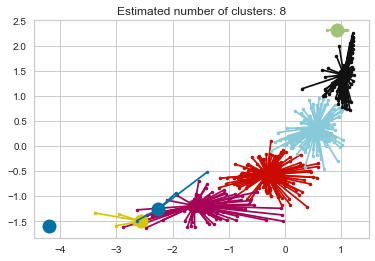

In [180]:
X = X_std

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-40, damping = 0.8).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [160]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 1, 1: 4, 2: 129, 3: 129, 4: 74, 5: 5, 6: 93, 7: 4}

In [162]:
df['Clusters_AF'] = pd.DataFrame(labels)
result_2 = pd.concat([result_2, df['Clusters_AF']], axis=1)

In [163]:
#result_2.drop(['Clusters_AF'], axis = 1, inplace = True)
result_2.head()

,ego_id,num_nodes,num_communities,modularity,num_components,density,node_coverage,giant_component_coverage,avg_degree,perc_important_nodes,mean_centrality,Summ_ID,Summ_RANK,Role,Teamplay,Summ_totalGames,result,Cluster,Clusters_AF
0,19459077,18,0.028986,0.042192,0.014493,0.389706,0.061594,1.000000,6.235294,0.058824,0.046569,19459077,BRONZE,Bot - ADC,Equipo completo premade,69,0,6,0
1,20501992,22,0.428571,0.538265,0.285714,0.190476,0.750000,0.809524,3.809524,0.095238,0.036090,20501992,BRONZE,Bot - ADC,Premade de dos personas,7,1,2,7
2,23407188,673,0.470874,0.807652,0.412621,0.005314,0.815534,0.491071,3.565476,0.007440,0.000517,23407188,BRONZE,Support,Premade de dos personas,206,1,5,3
3,27281117,45,0.351351,0.185415,0.081081,0.110994,0.297297,0.818182,4.772727,0.090909,0.015781,27281117,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de tres o cuatro,37,2,7,5
4,28306135,329,0.243243,0.788217,0.225225,0.011617,0.738739,0.634146,3.798780,0.015244,0.002134,28306135,BRONZE,"No tengo preferencia alguna, relleno el hueco ...",Premade de dos personas,111,1,0,2


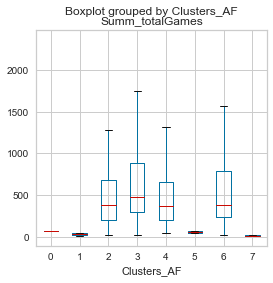

In [173]:
result_2.boxplot(column="Summ_totalGames",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (4,4))        # Figure size

# grups 1/3/4/6/8 corresponen a jugadors amb SUFICIENTS partides

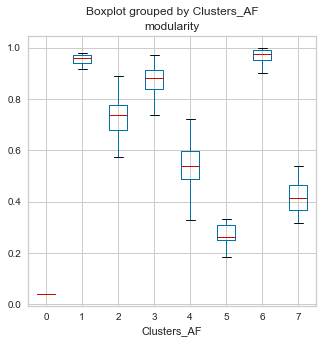

In [174]:
result_2.boxplot(column="modularity",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (5,5))        # Figure size

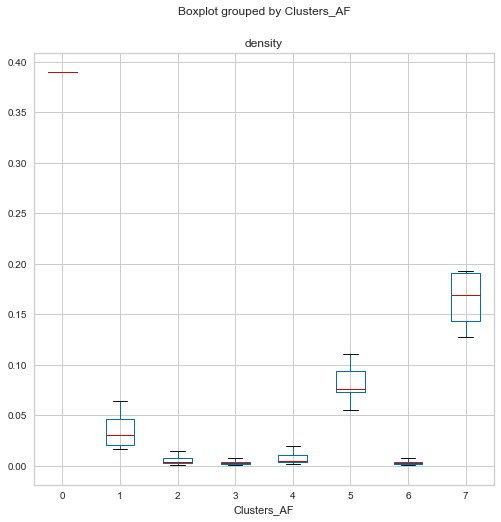

In [167]:
result_2.boxplot(column="density",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (8,8))        # Figure size

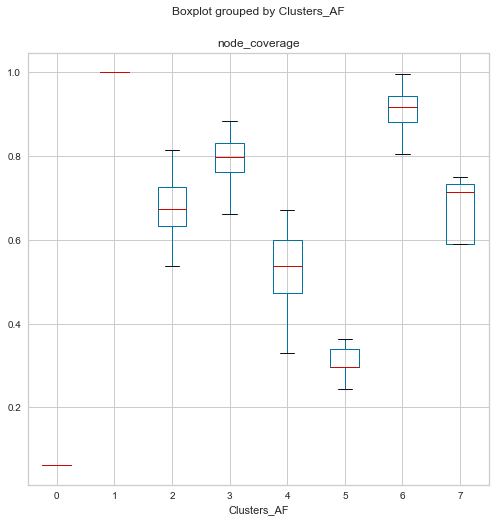

In [168]:
result_2.boxplot(column="node_coverage",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (8,8))        # Figure size

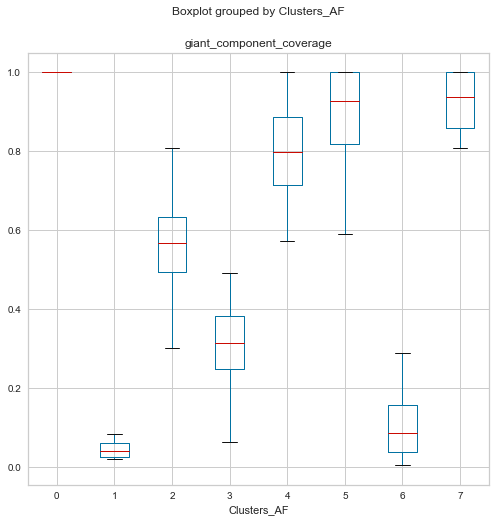

In [169]:
result_2.boxplot(column="giant_component_coverage",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (8,8))        # Figure size

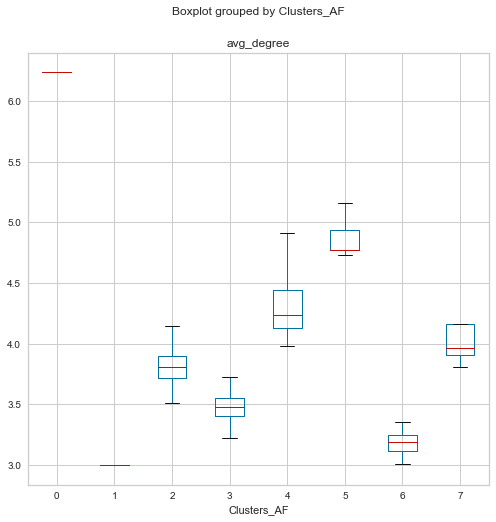

In [171]:
result_2.boxplot(column="avg_degree",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (8,8))        # Figure size

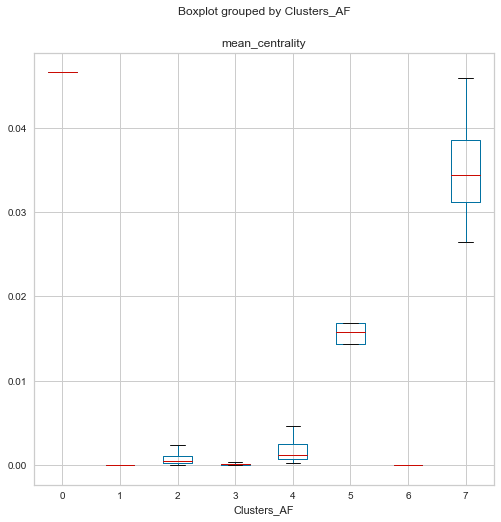

In [172]:
result_2.boxplot(column="mean_centrality",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (8,8))        # Figure size

# VOY A VER QUÉ PASA SI ME CARGO LOS QUE TIENEN POCAS PARTIDAS (GRUPOS 0,2,5,7)

In [92]:
egonets_data_70 = egonets_data[egonets_data['Summ_totalGames']>69]
egonets_data_70.shape

(401, 17)

In [ ]:
#result_2.groupby('Clusters_AF').min()

In [93]:
variable_names = ['Modularity', 'Components', 'Density', 'Coverage', 'Giant_Component_Coverage', 
                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']

egonets_data_numeric = egonets_data_70.iloc[:,3:11]
X = egonets_data_numeric.values
X

array([[  8.07651522e-01,   4.12621359e-01,   5.31367540e-03, ...,
          3.56547619e+00,   7.44047619e-03,   5.17286624e-04],
       [  7.88217271e-01,   2.25225225e-01,   1.16170657e-02, ...,
          3.79878049e+00,   1.52439024e-02,   2.13422070e-03],
       [  9.71878858e-01,   7.00000000e-01,   5.05557722e-03, ...,
          3.23556942e+00,   6.24024961e-03,   4.67072674e-05],
       ..., 
       [  8.56289656e-01,   5.35785288e-01,   1.03072028e-03, ...,
          3.44982079e+00,   8.96057348e-03,   5.27913730e-05],
       [  5.54365998e-01,   1.85185185e-01,   1.45985401e-02, ...,
          4.00000000e+00,   2.54545455e-02,   2.18069036e-03],
       [  7.06435846e-01,   2.58928571e-01,   6.59476730e-03, ...,
          3.96345515e+00,   1.49501661e-02,   9.16891928e-04]])

In [41]:
X_std = StandardScaler().fit_transform(X)

Estimated number of clusters: 9
Silhouette Coefficient: 0.518


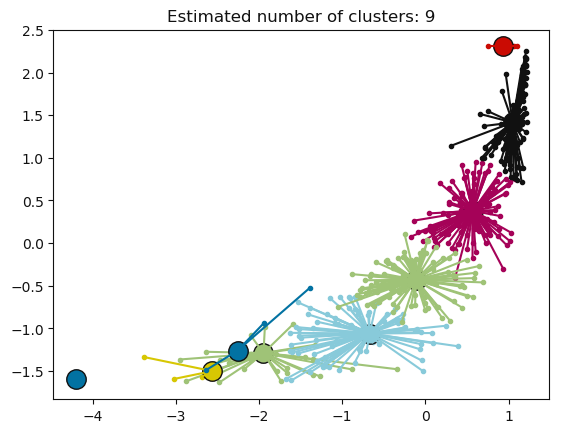

In [42]:
X = X_std

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 8
Silhouette Coefficient: 0.566


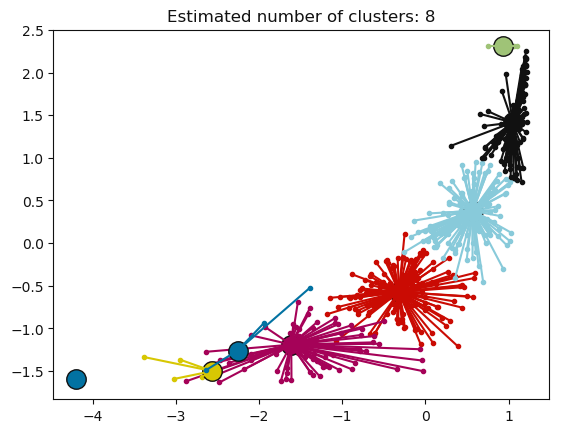

In [43]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
plt.style.use('default')

af = AffinityPropagation(preference=-50, damping = 0.8).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig('aff_clust_1.png', bbox_inches='tight')
plt.show()

In [32]:
i = -100
x = []
y = []
while i < 0:
    af = AffinityPropagation(preference=i).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    x.append(i)
    y.append(n_clusters_)
    i = i + 5



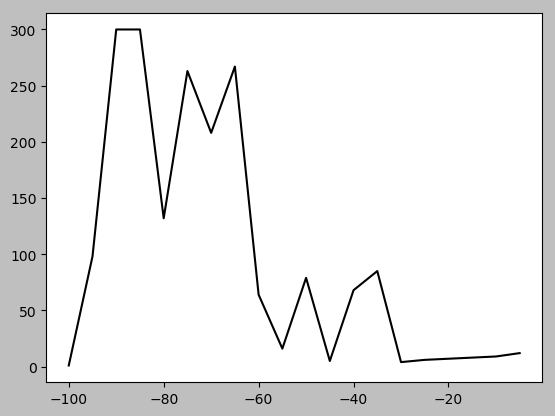

In [33]:
plt.style.use('grayscale')
plt.plot(x,y)
plt.show()

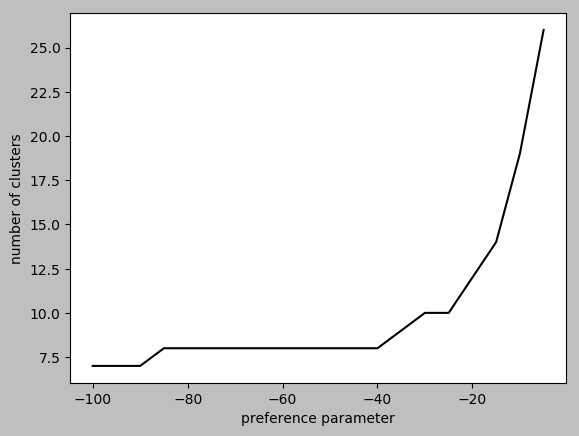

In [44]:
i = -100
x = []
y = []
while i < 0:
    af = AffinityPropagation(preference=i, damping = 0.8).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    x.append(i)
    y.append(n_clusters_)
    i = i + 5
    
plt.style.use('grayscale')
plt.grid(False)
plt.xlabel('preference parameter')
plt.ylabel('number of clusters')
plt.plot(x,y)
plt.savefig('preference_1.png', bbox_inches='tight')
plt.show()

In [181]:
af

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.8, max_iter=200, preference=-40, verbose=False)

array([[  -0.        , -121.18398857, -399.45805979, ..., -345.88998801,
        -369.96137498, -267.36850781],
       [-121.18398857,   -0.        , -116.86591315, ..., -102.5472482 ,
        -111.93897772,  -73.73220783],
       [-399.45805979, -116.86591315,   -0.        , ...,   -6.2447693 ,
          -2.6375514 ,  -23.79446369],
       ..., 
       [-345.88998801, -102.5472482 ,   -6.2447693 , ...,   -0.        ,
          -1.21653878,   -6.82813444],
       [-369.96137498, -111.93897772,   -2.6375514 , ...,   -1.21653878,
          -0.        ,  -12.74668203],
       [-267.36850781,  -73.73220783,  -23.79446369, ...,   -6.82813444,
         -12.74668203,   -0.        ]])

# PROVES MENYS VARIABLES

Estimated number of clusters: 4
Silhouette Coefficient: 0.641


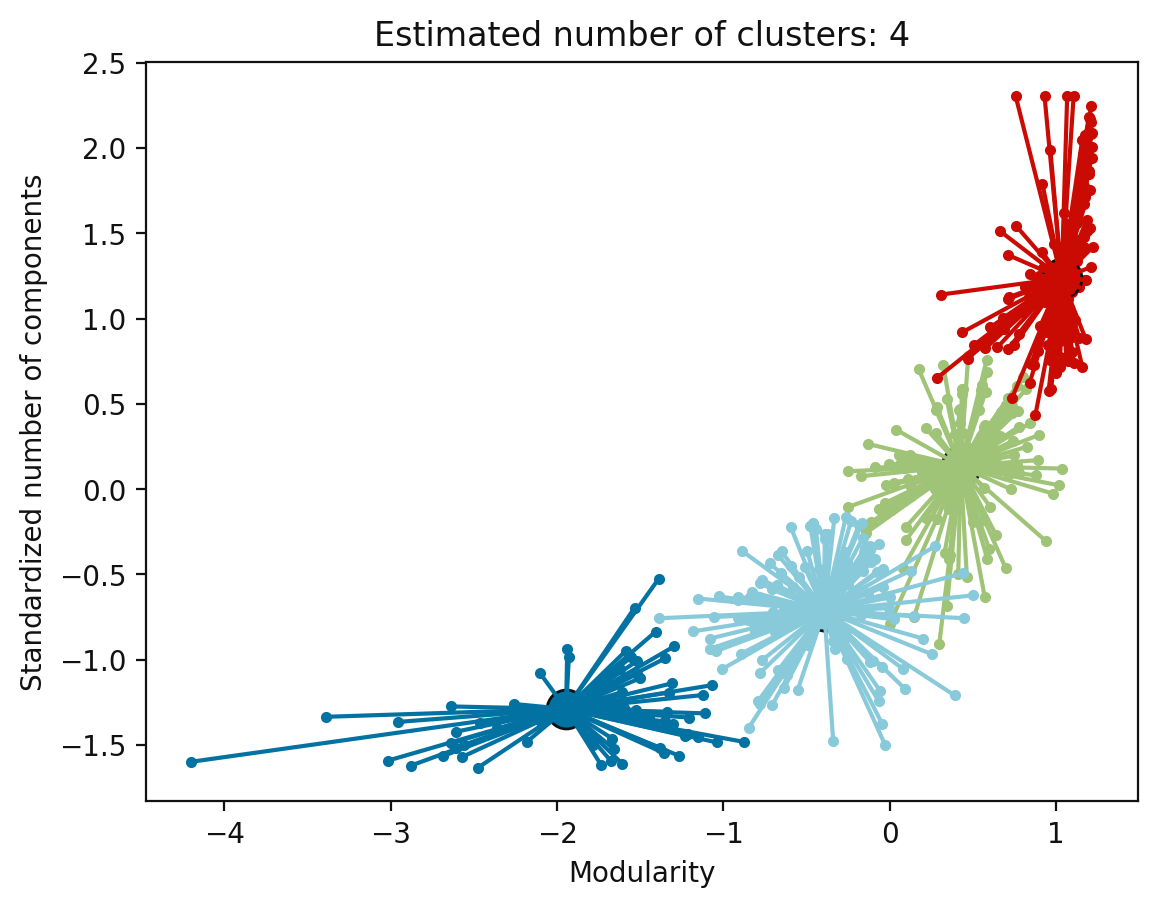

In [108]:
variable_names = ['Modularity', 'Components', 'Density', 'Coverage', 'Giant_Component_Coverage', 
                  'AVG_degree','Perc_Important_Nodes', 'AVG_centrality']
# 3 'Modularity', 4 'Components', 5 'Density', 6 'Coverage', 7 'Giant_Component_Coverage', 
# 8 'AVG_degree', 9 'Perc_Important_Nodes', 10 'AVG_centrality'
#egonets_data_numeric = egonets_data.iloc[:,3:11]

egonets_data_numeric = egonets_data.iloc[:,[3,4,7]]

# si trec el 6, millora. Si trec el 10, baixa a 6 clusters i millor fit. Si li trec el 5, encara millor fit.
# el 8 no li importa, el 9 tampoc 

X = egonets_data_numeric.values
X = StandardScaler().fit_transform(X)

plt.style.use('default')

from sklearn.cluster import AffinityPropagation
from sklearn import metrics
# #############################################################################
# Compute Affinity Propagation
af = AffinityPropagation(preference=-30, damping = 0.8).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrc')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig('aff_clust_2.png', bbox_inches='tight')
plt.xlabel('Modularity')
plt.ylabel('Standardized number of components')

plt.show()

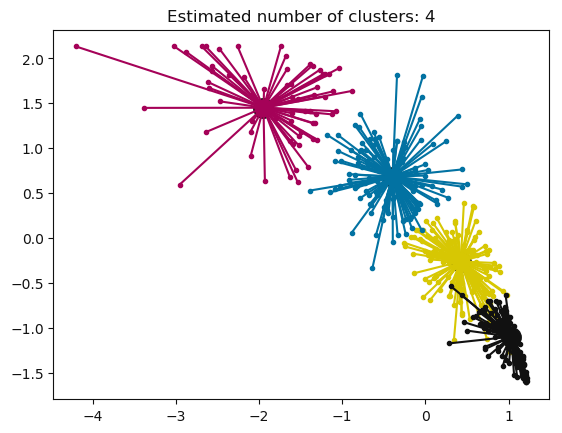

In [47]:
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 2], col + '.')
    plt.plot(cluster_center[0], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[2], x[2]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig('aff_clust_0_2.png', bbox_inches='tight')
plt.show()

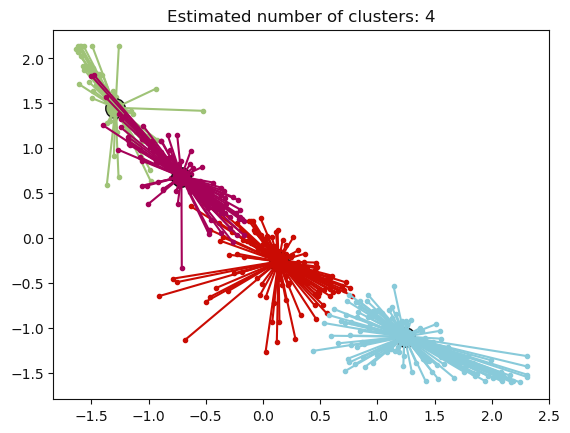

In [48]:
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 1], X[class_members, 2], col + '.')
    plt.plot(cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[1], x[1]], [cluster_center[2], x[2]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.savefig('aff_clust_1_2.png', bbox_inches='tight')
plt.show()

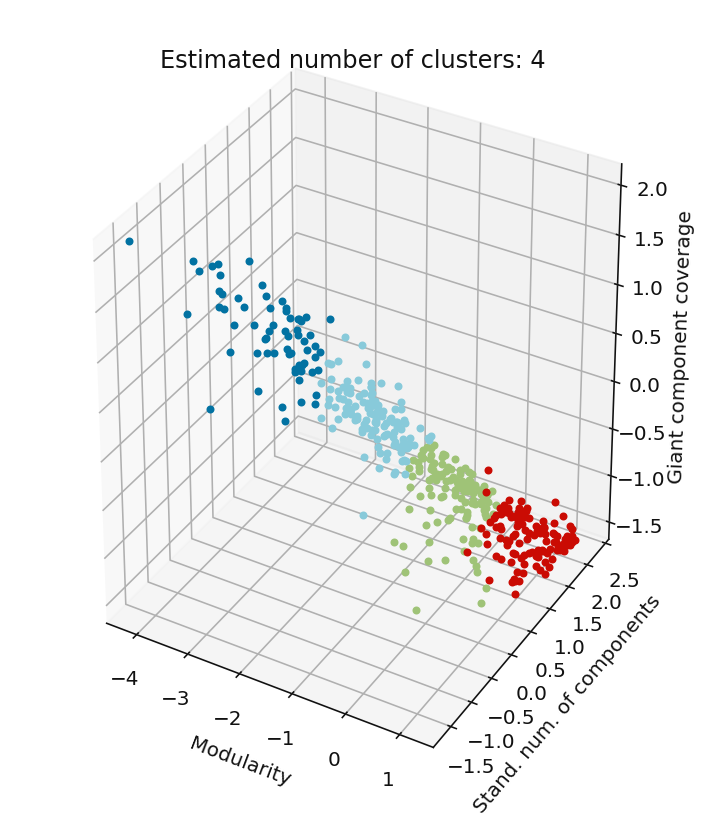

In [112]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax),  np.diag([1, 1, 1, 1]))

for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    ax.plot3D(X[class_members, 0], X[class_members, 1], X[class_members, 2], col + '.')
    #ax.plot3D([cluster_center[0]], [cluster_center[1]], [cluster_center[2]], c=col, marker='o')
              #, 'o', markerfacecolor=col,
            # markeredgecolor='k', s=14)
    #for x in X[class_members]:
    #    plt.plot([cluster_center[1], x[1]], [cluster_center[2], x[2]], col)
    

fig.subplots_adjust(bottom=-0.15,top=1.2)
ax = fig.gca(projection='3d')
ax.set_xlabel('Modularity')
ax.set_ylabel('Stand. num. of components')
ax.set_zlabel('Giant component coverage')
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.figsize= (8,8)
plt.savefig('aff_clust_0_2.png', bbox_inches='tight')

In [103]:
colors

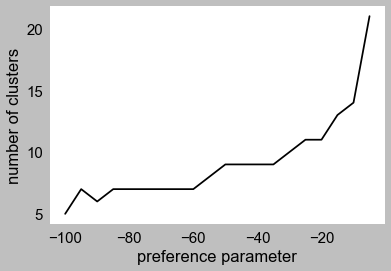

In [45]:
i = -100
x = []
y = []
while i < 0:
    af = AffinityPropagation(preference=i, damping = 0.8).fit(X)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    x.append(i)
    y.append(n_clusters_)
    i = i + 5
    
    
plt.style.use('grayscale')
plt.grid(False)
plt.xlabel('preference parameter')
plt.ylabel('number of clusters')
plt.plot(x,y)
plt.savefig('preference_2.png', bbox_inches='tight')
plt.show()

In [47]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 65, 1: 129, 2: 120, 3: 125}

In [48]:
df['Clusters_AF'] = pd.DataFrame(labels)
result_2 = pd.concat([result_2, df['Clusters_AF']], axis=1)

NameError: name 'df' is not defined

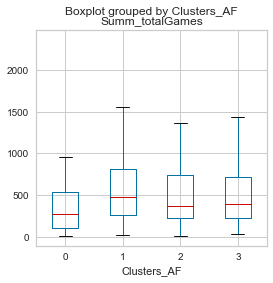

In [215]:
result_2.boxplot(column="Summ_totalGames",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (4,4))        # Figure size


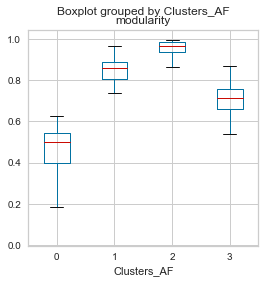

In [216]:
result_2.boxplot(column="modularity",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (4,4))        # Figure size

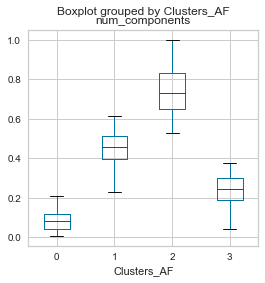

In [218]:
result_2.boxplot(column="num_components",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (4,4))        # Figure size

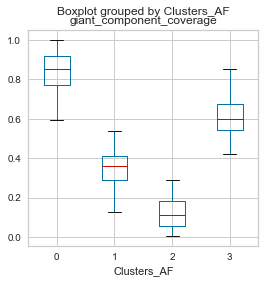

In [221]:
result_2.boxplot(column="giant_component_coverage",        # Column to plot
                 by= "Clusters_AF",         # Column to split upon
                 figsize= (4,4))        # Figure size

In [222]:
result_2.to_csv('clustering.csv',index = False)

In [3]:
clusters = pd.read_csv('clustering.csv')

In [4]:
clusters.loc[clusters['Clusters_AF']==0,'Clusters_AF'] = 'C1'
clusters.loc[clusters['Clusters_AF']==3,'Clusters_AF'] = 'C2'
clusters.loc[clusters['Clusters_AF']==1,'Clusters_AF'] = 'C3'
clusters.loc[clusters['Clusters_AF']==2,'Clusters_AF'] = 'C4'

In [5]:
clusters.to_csv('clustering_tesis.csv',index = False)

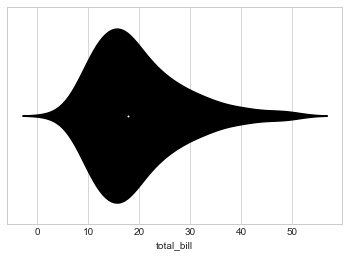

In [55]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.violinplot(x=tips["total_bill"])


In [93]:
games = clusters[['Summ_totalGames', 'Clusters_AF']]
modularity = clusters[['modularity', 'Clusters_AF']]
giant_comp = clusters[['giant_component_coverage', 'Clusters_AF']]
num_comp = clusters[['num_components', 'Clusters_AF']]

[Text(0,0.5,'Total Games'), Text(0.5,0,'Cluster')]

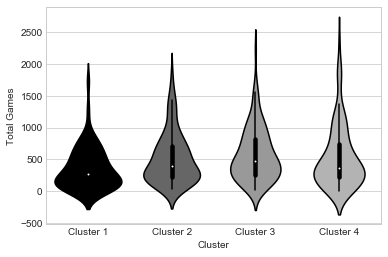

In [83]:
ax = sns.violinplot(x='Clusters_AF', y='Summ_totalGames', data=games, order = ['Cluster 1','Cluster 2','Cluster 3', 'Cluster 4'])
ax.set(xlabel='Cluster', ylabel='Total Games')

[Text(0,0.5,'Modularity'), Text(0.5,0,'Cluster')]

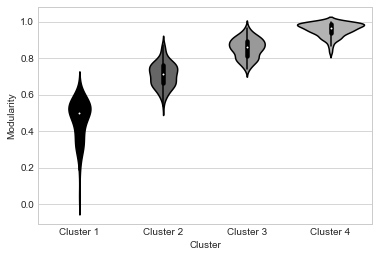

In [84]:
ax = sns.violinplot(x='Clusters_AF', y='modularity', data=modularity, order = ['Cluster 1','Cluster 2','Cluster 3', 'Cluster 4'])
ax.set(xlabel='Cluster', ylabel='Modularity')

[Text(0,0.5,'Standardized Number of Components'), Text(0.5,0,'Cluster')]

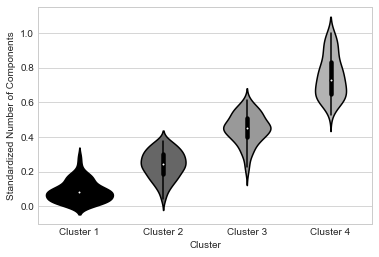

In [85]:
ax = sns.violinplot(x='Clusters_AF', y='num_components', data=num_comp, order = ['Cluster 1','Cluster 2','Cluster 3', 'Cluster 4'])
ax.set(xlabel='Cluster', ylabel='Standardized Number of Components')

[Text(0,0.5,'Largest Component Proportion'), Text(0.5,0,'Cluster')]

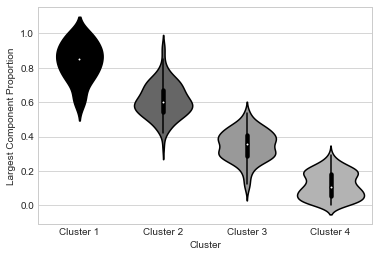

In [86]:
ax = sns.violinplot(x='Clusters_AF', y='giant_component_coverage', data=giant_comp, order = ['Cluster 1','Cluster 2','Cluster 3', 'Cluster 4'])
ax.set(xlabel='Cluster', ylabel='Largest Component Proportion')

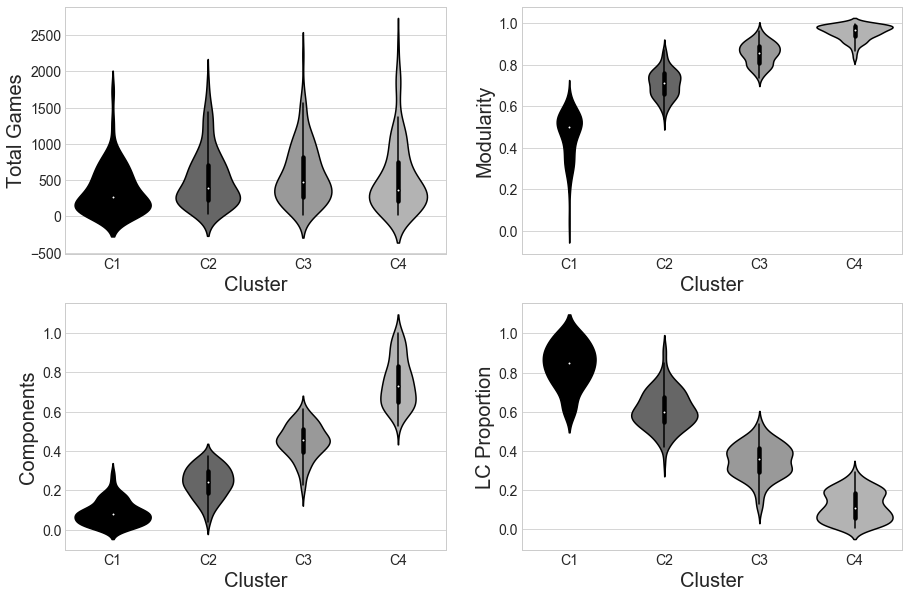

In [129]:
SMALL_SIZE = 14
MEDIUM_SIZE = 20
BIGGER_SIZE = 6

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)

sns.violinplot(x='Clusters_AF', y='Summ_totalGames', data=games, order = ['C1','C2','C3', 'C4'], ax = ax1)
ax1.set(xlabel='Cluster', ylabel='Total Games')

ax2 = sns.violinplot(x='Clusters_AF', y='modularity', data=modularity, order = ['C1','C2','C3', 'C4'], ax = ax2)
ax2.set(xlabel='Cluster', ylabel='Modularity')

ax3 = sns.violinplot(x='Clusters_AF', y='num_components', data=num_comp, order = ['C1','C2','C3', 'C4'], ax = ax3)
ax3.set(xlabel='Cluster', ylabel='Components')

ax3 = sns.violinplot(x='Clusters_AF', y='giant_component_coverage', data=giant_comp, order = ['C1','C2','C3', 'C4'], ax = ax4)
ax4.set(xlabel='Cluster', ylabel='LC Proportion')

#fig.tight_layout() # Fix the margins.
fig.set_size_inches(15, 10)
plt.savefig('network_attributes_by_cluster.png', bbox_inches='tight')



In [132]:
clusters=clusters[['Summ_totalGames', 'modularity','giant_component_coverage','num_components', 'Clusters_AF']]



In [140]:
clusters.to_csv('clusters_R.csv',index = False)